In [1]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Preprocess images

In [3]:
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

### Cache features

In [4]:
DATA_PATH = './datasets/words_captcha/'
image_names = os.listdir(DATA_PATH)

image_names.sort(key=lambda x: int(x.split('.')[0][1:]))
image_names = [os.path.join(DATA_PATH, img) for img in image_names]

with open("./datasets/spec_train_val.txt", "r", encoding='utf-8') as file:
    labels = [line.strip() for line in file]

labels = [label.split(' ')[1] for label in labels]

In [5]:
from tqdm import tqdm

# DATA_PATH = './datasets/words_captcha/'
# image_names = os.listdir(DATA_PATH)

# image_names.sort(key=lambda x: int(x.split('.')[0][1:]))
# image_names = image_names[72900:-1]
# image_names = [os.path.join(DATA_PATH, img) for img in image_names]

# image_dataset = tf.data.Dataset.from_tensor_slices(image_names)
# image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
#                             .batch(16)
                            
# for img, path in tqdm(image_dataset):
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features,
#                                 (batch_features.shape[0], -1, batch_features.shape[3]))
    
#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         np.save(path_of_feature, bf.numpy())

### Preprocess label and tokenize

In [6]:
chars_train = [list(char_train) for char_train in labels]
chars_train = [['<start>'] + char_list + ['<end>'] for char_list in chars_train]

# Char level
# char_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, filters='')
char_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=100)

char_tokenizer.fit_on_texts(chars_train)

train_seqs = char_tokenizer.texts_to_sequences(chars_train)

char_tokenizer.word_index['<pad>'] = 0
char_tokenizer.index_word[0] = '<pad>'

train_seqs = char_tokenizer.texts_to_sequences(chars_train)

max_length = 7

label_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)

char_index_mapping = char_tokenizer.word_index
print([char_tokenizer.index_word[idx] for idx in label_vector[0]])
print(label_vector[0])
print("Total index:", len(char_index_mapping))

['<start>', 't', 'h', 'u', 's', '<end>', '<pad>']
[ 1  8 17 16  5  2  0]
Total index: 29


### Split Dataset

In [7]:
img_name_train, img_name_val = image_names[:100000], image_names[100000:120000]
label_train, label_val = label_vector[:100000], label_vector[100000:]

len(img_name_train), len(label_train), len(img_name_val), len(label_val)

(100000, 100000, 20000, 20000)

### Hyper-parameters

In [8]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 32
BUFFER_SIZE = 200
embedding_dim = 256
units = 512
vocab_size = len(char_tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from Resnet101v2 is (49, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 49
print(f"Vocab size: {vocab_size}")

Vocab size: 30


### Create a tf.data dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: <start>she<end><pad><pad>


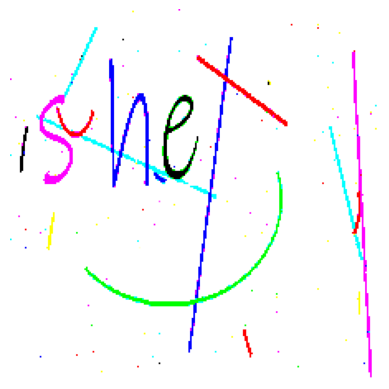

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: <start>grid<end><pad>


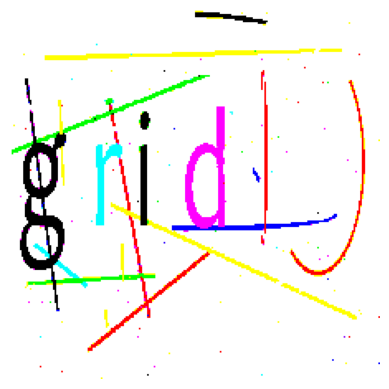

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, label_train))
dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

for idx, (img_tensor_batch, label_batch) in enumerate(dataset):
    for i in range(BATCH_SIZE):
        image = img_tensor_batch[i].numpy()
        # label = label_batch[i].numpy().decode('utf-8')
        char_seq = [char_tokenizer.index_word[idx] for idx in label_batch[i].numpy()]
        label = ''.join(char_seq)
        print("Label:", label)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        if(i == 1): break
    break

### Model

In [10]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 49, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 49, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 49, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [11]:
# class CNN_Encoder(tf.keras.Model):
#     # Since you have already extracted the features and dumped it using pickle
#     # This encoder passes those features through a Fully connected layer
#     def __init__(self, embedding_dim):
#         super(CNN_Encoder, self).__init__()
#         # shape after fc == (batch_size, 49, embedding_dim)
#         self.dw_conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same')
#         self.dw_conv2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding='same')
#         self.dw_conv3 = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=2, padding='same')
#         self.dw_conv4 = tf.keras.layers.Conv2D(filters=2048, kernel_size=(3, 3), strides=2, padding='same')
#         # self.dw_conv5 = tf.keras.layers.Conv2D(filters=2048, kernel_size=(3, 3), strides=2, padding='same')
#         self.bn1 = tf.keras.layers.BatchNormalization()
#         self.bn2 = tf.keras.layers.BatchNormalization()
#         self.bn3 = tf.keras.layers.BatchNormalization()
#         self.bn4 = tf.keras.layers.BatchNormalization()
#         # self.bn5 = tf.keras.layers.BatchNormalization()
#         self.max_pool = tf.keras.layers.MaxPooling2D()
#         self.relu = tf.keras.layers.ReLU()
#         self.fc = tf.keras.layers.Dense(embedding_dim)

#     def call(self, x):
#         x = self.dw_conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.dw_conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.max_pool(x)
#         x = self.dw_conv3(x)
#         x = self.bn3(x)
#         x = self.relu(x)
#         x = self.dw_conv4(x)
#         x = self.bn4(x)
#         x = self.relu(x)
#         # x = self.dw_conv5(x)
#         # x = self.bn5(x)
#         # x = self.relu(x)
#         x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
#         x = self.fc(x)
#         x = tf.nn.relu(x)
#         return x

In [12]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.feature_extractor = tf.keras.applications.resnet50.ResNet50(include_top=False)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.feature_extractor(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [13]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        # attention_weights shape == (batch_size, 49, 1)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape = (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape = (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [14]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [16]:
checkpoint_path = "./checkpoints/captcha"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [17]:
start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#     start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print(ckpt_manager.latest_checkpoint)
#     print("Restore")

In [18]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [19]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([char_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
    # dec_input = tf.expand_dims(target[:, 0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [20]:
EPOCHS = 10
start = time.time()
for epoch in range(start_epoch, EPOCHS):
    
    total_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(dataset), total=num_steps):
        # batch_features = image_features_extract_model(img_tensor)
        # batch_features = tf.reshape(batch_features,
        #                       (batch_features.shape[0], -1, batch_features.shape[3]))
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

#         if batch % 100 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(
#               epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    # if epoch % 5 == 0:
    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
print ('Time taken for {} epoch {} sec\n'.format(EPOCHS, time.time() - start))

100%|██████████| 3125/3125 [13:50<00:00,  3.76it/s]


Epoch 1 Loss 0.579685


100%|██████████| 3125/3125 [13:29<00:00,  3.86it/s]


Epoch 2 Loss 0.034805


100%|██████████| 3125/3125 [13:29<00:00,  3.86it/s]


Epoch 3 Loss 0.024987


100%|██████████| 3125/3125 [13:29<00:00,  3.86it/s]


Epoch 4 Loss 0.016811


100%|██████████| 3125/3125 [13:29<00:00,  3.86it/s]


Epoch 5 Loss 0.015916


100%|██████████| 3125/3125 [13:28<00:00,  3.86it/s]


Epoch 6 Loss 0.011793


100%|██████████| 3125/3125 [13:28<00:00,  3.86it/s]


Epoch 7 Loss 0.011082


100%|██████████| 3125/3125 [13:28<00:00,  3.87it/s]


Epoch 8 Loss 0.009648


100%|██████████| 3125/3125 [13:28<00:00,  3.87it/s]


Epoch 9 Loss 0.008396


100%|██████████| 3125/3125 [13:28<00:00,  3.86it/s]


Epoch 10 Loss 0.008156
Time taken for 10 epoch 8126.6600642204285 sec



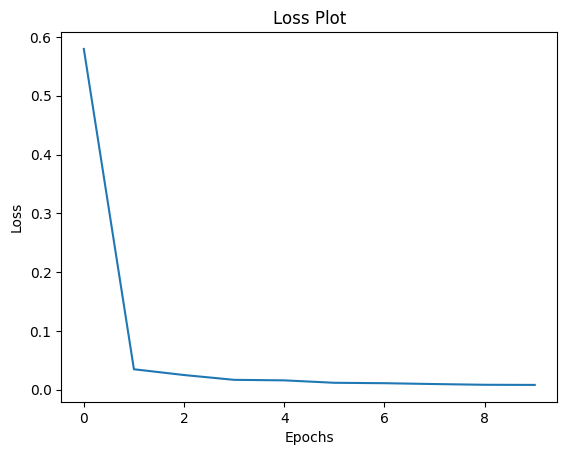

In [21]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### CAPTCHA!

In [38]:
ckpt.restore('./checkpoints/captcha/ckpt-10')

In [22]:
def evaluate(image, label):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input, label = load_image(image, label)
    temp_input = tf.expand_dims(temp_input, 0)
    # img_tensor_val = image_features_extract_model(temp_input)
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(temp_input)

    dec_input = tf.expand_dims([char_tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(char_tokenizer.index_word[predicted_id])

        if char_tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [24]:
count = 0
iter = 0
for image, label in zip(img_name_val, label_val):
    pred, _ = evaluate(image, label)
    pred = pred[:-1]
    start_index = np.where(label == 1)[0][0]
    end_index = np.where(label == 2)[0][0]
    label = label[start_index + 1: end_index]
    label = [char_tokenizer.index_word[idx] for idx in label]
    label_str = ''.join(label)
    pred_str = ''.join(pred)
    # print(label_str, pred_str)
    if(pred == label): count += 1
    iter += 1
    if(iter % 1000 == 0):
        print(f"Now Count: {count} / {iter}")

print("Validation accuracy:", count / len(img_name_val))

Now Count: 986 / 1000
Now Count: 1975 / 2000
Now Count: 2960 / 3000
Now Count: 3949 / 4000
Now Count: 4939 / 5000
Now Count: 5927 / 6000
Now Count: 6911 / 7000
Now Count: 7899 / 8000
Now Count: 8891 / 9000
Now Count: 9881 / 10000
Now Count: 10865 / 11000
Now Count: 11842 / 12000
Now Count: 12829 / 13000
Now Count: 13817 / 14000
Now Count: 14808 / 15000
Now Count: 15793 / 16000
Now Count: 16783 / 17000
Now Count: 17777 / 18000
Now Count: 18769 / 19000
Now Count: 19756 / 20000
Validation accuracy: 0.9878


In [28]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> m i t <end>
Prediction Caption: m i t <end>


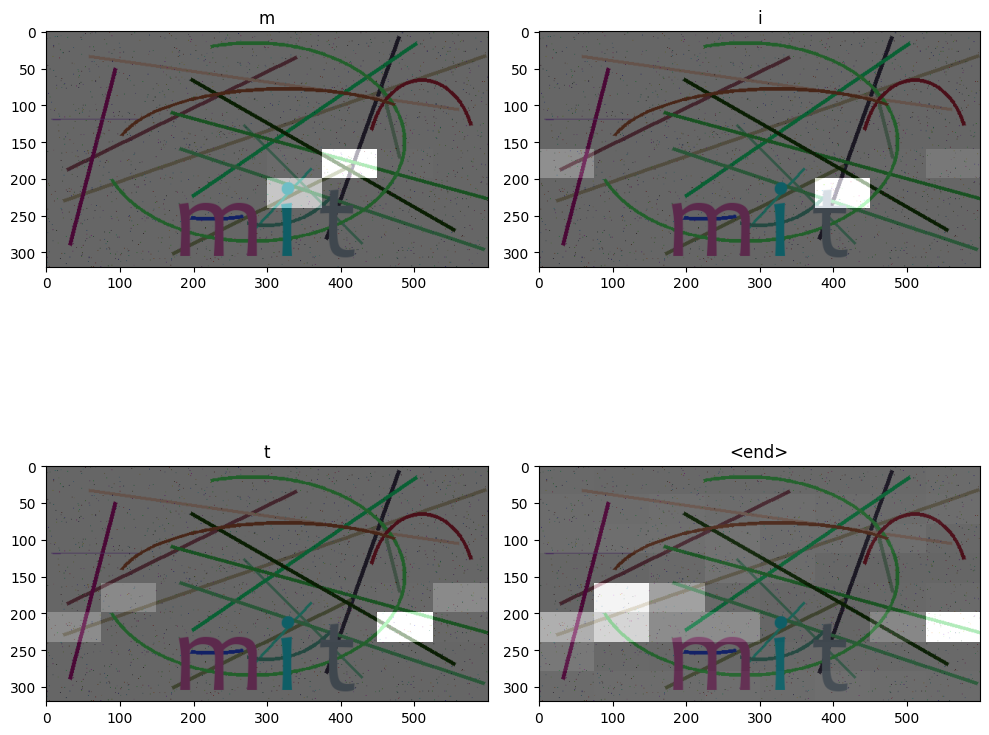

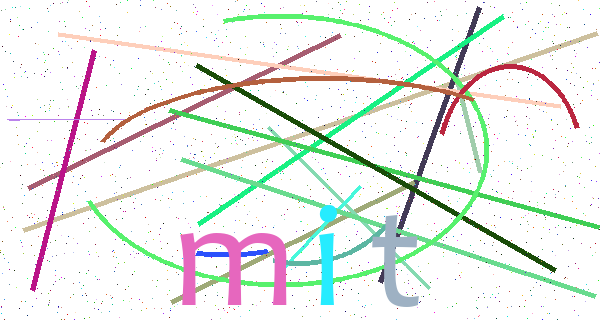

In [29]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([char_tokenizer.index_word[i] for i in label_val[rid] if i not in [0]])
result, attention_plot = evaluate(image, 0)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

### Predict test data

In [30]:
DATA_PATH = './datasets/words_captcha/'
image_names = os.listdir(DATA_PATH)

image_names.sort(key=lambda x: int(x.split('.')[0][1:]))

img_name_test = image_names[120000:]

print(len(img_name_test))

20000


In [32]:
with open('./spec_test.txt', 'w', encoding='utf-8') as file:
    count = 0
    for image_name in img_name_test:
        pred, _ = evaluate(DATA_PATH + image_name, 0)
        pred = pred[:-1]
        pred_str = ''.join(pred)
        file.write(image_name.split('.')[0] + ' ' + pred_str + '\n')
        count += 1
        if(count % 1000 == 0):
            print("Now iter:", count)

Now iter: 1000
Now iter: 2000
Now iter: 3000
Now iter: 4000
Now iter: 5000
Now iter: 6000
Now iter: 7000
Now iter: 8000
Now iter: 9000
Now iter: 10000
Now iter: 11000
Now iter: 12000
Now iter: 13000
Now iter: 14000
Now iter: 15000
Now iter: 16000
Now iter: 17000
Now iter: 18000
Now iter: 19000
Now iter: 20000


## Report

### Tokenizer

因為每一個time step都是predict一個字元，所以在tokenizer的部分要將字串拆解成一個又一個的字元，並且添加<start>和<end>，便形成了一個char list，隨後就將每一個char list放進tokenizer裡面轉換出sequences。而因為一個index對應一個char，所以最後只會有26個英文字母加上<start>, <end>, <pad>這三個特殊字元，形成整個mapping，長度不會超出所設置的num_words=100

### Feature Extractor

在feature extractor上我有嘗試了三種方式：

第一種是使用DenseNet201作為pretrained好的feature extractor，但是因為我freeze住了weight，所以可以訓練的地方只有CNN的FC和RNN而已，loss最終降到1.1左右就接近收斂了，但是validation accuracy卻只有23%；

第二種方式是自己手刻的CNN，因為在網路上查找相關做驗證碼解析的任務，很多使用的都是自己手刻的CNN，並且架構都算簡單，所以就自己嘗試使用Convolution, Batch Normalization, Relu兜成一個block並且重複4次。該模型搭配上RNN的loss最終可以收斂到0.015左右，accuracy則是可以來到88%，雖然若是調整一下架構或是再fine tune一下應該可以突破0.90大關，但覺得只超過一些的話不太保險，就想到還是可以使用pretrained model，但是讓weight可以train，於是便是第三種方式。

第三種方式使用ResNet50搭配可訓練的weight，沒有使用DenseNet201是因為訓練過程太久了，所以挑了一個訓練上比較快的作為feature extractor。而改使用ResNet50之後，僅僅train了10個epochs的loss就降到了0.008，在validation accuracy則是來到98%。
